# Graph WebSearch Agent

In this project, we are going to build a Graph Web Search Agent. The Agent will take a research question as input, and we'll employ some agents to address the user question. 

Since some research question might be hard to reason and to answer. We are going to split the task, and different agents will take care of

- planning what are the steps necessary to answer the question
- filter the relevant documents that were found in the web
- generate a report from the documents retrieved.


## 1. Architecture

The solution implemented will follow the architecture shown below:

<img src="../images/graph.png" alt="architecture" width="600">

## 2. State

As a first step, let's implement the state of the graph. The state structure and attributes are shown below:

<img src="../images/states.png" alt="states" width="300">

<img src="../images/state_attributes.png" alt="attributes" width="400">

In [124]:
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, List, Literal
from langgraph.graph.message import add_messages


class PlannerOutput(BaseModel):
    search_term: str = Field(
        description="The most relevant search term to start with",
    )
    overall_strategy: str = Field(
        description="The overall strategy to guide the search process"
    )
    additional_information: Annotated[List[str], add_messages] = Field(
        description="Any additional information to guide the search including other search terms or filters"
    )


class SelectorOutput(BaseModel):
    selected_page_url: str = Field(
        description="The exact URL of the page you selected"
    )
    description: str = Field(
        description="A brief description of the page"
    )
    reason_for_selection: str = Field(
        description="Why you selected this page"
    )
    
    
class ReviewerOutput(BaseModel):
    feedback: str = Field(
        description="precise feedback on what is required to pass the review."
    )
    pass_review: Literal["True", "False"] = Field(
        description="whether the review will pass or not."
    )
    comprehensive: Literal["True", "False"] = Field(
        description="whether the review is comprehensive."
    )
    citations_provided: Literal["True", "False"] = Field(
        description="whether citations are provided."
    )
    relevant_to_research_question: Literal["True", "False"] = Field(
        description="whether the report is relevant to the research question."
    )


class RouterOutput(BaseModel):
    next_agent: Literal["planner", "selector", "reporter", "print_report"] = Field(
        description="the next node of the graph to be executed."
    )


class AgentGraphState(TypedDict):
    research_question: str
    
    # agents
    planner_response: PlannerOutput
    selector_response: SelectorOutput
    reporter_response: Annotated[list, add_messages]r
    reviewer_response: ReviewerOutput
    router_response: RouterOutput
    
    # tools
    serper_response: Annotated[list, add_messages]  # aka search engine results page
    scraper_response: Annotated[list, add_messages] 

## 3. Nodes

Once we have the Graph State, we can start building the nodes. Nodes can be agents or tools, and we are going to define each one of them in the following cells.

In [2]:
from utils.utils import get_current_utc_datetime, check_for_content
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import List, Literal
from langgraph.graph import StateGraph, START, END

from pprint import pprint

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_openai import ChatOpenAI

MODEL = "gpt-4o-mini"
TEMPERATURE = 0

research_question = "why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?"

### Planner Agent

In [106]:
# planner agent
planner_prompt_template = PromptTemplate.from_template(
    """
    You are a planner. Your responsibility is to create a comprehensive plan to help your team answer a research question. 
    Questions may vary from simple to complex, multi-step queries. Your plan should provide appropriate guidance for your 
    team to use an internet search engine effectively.

    Focus on highlighting the most relevant search term to start with, as another team member will use your suggestions 
    to search for relevant information.

    If you receive feedback, you must adjust your plan accordingly. Here is the feedback received:
    Feedback: {feedback}

    Current date and time:
    {datetime}
    """
)

def planner(state: AgentGraphState):
    reviewer_response =  state.get("reviewer_response", None)
    if not reviewer_response:
        feedback = None
    else:
        feedback = reviewer_response.feedback

    planner_prompt = planner_prompt_template.format(
        feedback=feedback,
        datetime=get_current_utc_datetime()
    )

    messages = [
        SystemMessage(content=planner_prompt),
        HumanMessage(content=f"research_question: {research_question}")
    ]

    llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)
    structured_planner_llm = llm.with_structured_output(PlannerOutput)
    return {"planner_response": structured_planner_llm.invoke(messages)}

In [6]:
planner_graph = StateGraph(AgentGraphState)

planner_graph.add_node("planner", planner)

planner_graph.add_edge(START, "planner")
planner_graph.add_edge("planner", END)

planner_graph = planner_graph.compile()
planner_graph.invoke({"research_question": research_question})

{'research_question': 'why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?',
 'planner_response': PlannerOutput(search_term='Maringá warmest city Paraná', overall_strategy='Begin by searching for climate data and geographical information about Maringá. Look for studies or articles that discuss temperature averages, weather patterns, and any geographical features that contribute to its warmth. Additionally, explore local meteorological reports or government resources that may provide insights into the climate of the region.', additional_information=['Maringá climate data', 'Maringá temperature averages', 'geography of Maringá', 'climate studies Paraná', 'weather patterns Maringá']),
 'reporter_response': [],
 'serper_response': [],
 'scraper_response': [],
 'final_report': [],
 'end_chain': []}

So, basically, our planner agent seems to be behaving correctly. We still have to experiment it with feedback though, but we are going to do that later.

### WebSearch Tool

In this section, we are going to develop the websearch tool. We could simply use a langchain module for that, such as Tavily, but let's build our own search tool just because.

In [7]:
import os 
import requests
import json

# search_term = state.planner_response.search_term
search_term = research_question
search_url = "https://google.serper.dev/search"
headers = {
    'Content-Type': 'application/json',
    'X-API-KEY': os.environ["SERPER_API_KEY"]
}
payload = json.dumps({"q": search_term})

response = requests.request("POST", search_url, headers=headers, data=payload)
response.raise_for_status()
results = response.json()

Below, the results are displayed. We need to put them in a nice format to pass them to the selector agent.

In [8]:
results.keys()

dict_keys(['searchParameters', 'organic', 'peopleAlsoAsk', 'relatedSearches', 'credits'])

In [9]:
results["organic"]

[{'title': 'Maringá | Brazilian City, Tourist Destination - Britannica',
  'link': 'https://www.britannica.com/place/Maringa',
  'snippet': 'It lies on the Paraná Plateau, at an elevation of 169 feet (52 metres) above sea level. Maringá grew rapidly after its founding in 1947. Many of its residents ...',
  'attributes': {'Missing': 'warmest | Show results with:warmest'},
  'position': 1},
 {'title': 'Maringá - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Maring%C3%A1',
  'snippet': 'Maringá is a municipality in southern Brazil founded on 10 May 1947 as a planned urban area. It is the third largest city in the state of Paraná, ...',
  'attributes': {'Missing': 'warmest | Show results with:warmest'},
  'position': 2},
 {'title': 'My green hometown of Maringa, Brazil',
  'link': 'https://youthjournalism.org/my-green-hometown-of-maringa-brazil/',
  'snippet': "There are trees and lawns everywhere that add some color to the metropolitan landscape. That's why people also named Maring

In [10]:
results

{'searchParameters': {'q': 'why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?',
  'type': 'search',
  'engine': 'google'},
 'organic': [{'title': 'Maringá | Brazilian City, Tourist Destination - Britannica',
   'link': 'https://www.britannica.com/place/Maringa',
   'snippet': 'It lies on the Paraná Plateau, at an elevation of 169 feet (52 metres) above sea level. Maringá grew rapidly after its founding in 1947. Many of its residents ...',
   'attributes': {'Missing': 'warmest | Show results with:warmest'},
   'position': 1},
  {'title': 'Maringá - Wikipedia',
   'link': 'https://en.wikipedia.org/wiki/Maring%C3%A1',
   'snippet': 'Maringá is a municipality in southern Brazil founded on 10 May 1947 as a planned urban area. It is the third largest city in the state of Paraná, ...',
   'attributes': {'Missing': 'warmest | Show results with:warmest'},
   'position': 2},
  {'title': 'My green hometown of Maringa, Brazil',
   'link': 'https://youthjournalism.

In [11]:
def format_results(organic_results):
    result_strings = []
    for result in organic_results:
        title = result.get("title", "No Title")
        link = result.get("link", "#")
        snippet = result.get("snippet", "No snippet available")
        result_strings.append(f"Title: {title}\nLink: {link}\nSnippet: {snippet}\n---")
    
    return "\n".join(result_strings)

In [12]:
pprint(format_results(results["organic"]))

('Title: Maringá | Brazilian City, Tourist Destination - Britannica\n'
 'Link: https://www.britannica.com/place/Maringa\n'
 'Snippet: It lies on the Paraná Plateau, at an elevation of 169 feet (52 '
 'metres) above sea level. Maringá grew rapidly after its founding in 1947. '
 'Many of its residents ...\n'
 '---\n'
 'Title: Maringá - Wikipedia\n'
 'Link: https://en.wikipedia.org/wiki/Maring%C3%A1\n'
 'Snippet: Maringá is a municipality in southern Brazil founded on 10 May 1947 '
 'as a planned urban area. It is the third largest city in the state of '
 'Paraná, ...\n'
 '---\n'
 'Title: My green hometown of Maringa, Brazil\n'
 'Link: https://youthjournalism.org/my-green-hometown-of-maringa-brazil/\n'
 'Snippet: There are trees and lawns everywhere that add some color to the '
 "metropolitan landscape. That's why people also named Maringa the Green City, "
 'or ...\n'
 '---\n'
 'Title: Paraná (state) - Wikipedia\n'
 'Link: https://en.wikipedia.org/wiki/Paran%C3%A1_(state)\n'
 'Snippet: I

Okay, with the results in shape, let's create the node recycling the code we developed so far.

In [13]:
import os
import ast
import requests
import json
from langchain_community.utilities import GoogleSerperAPIWrapper


def google_serper(state: AgentGraphState):
    
    search_term = state["planner_response"].search_term
    search_url = "https://google.serper.dev/search"
    headers = {
        'Content-Type': 'application/json',
        'X-API-KEY': os.environ["SERPER_API_KEY"]
    }
    payload = json.dumps({"q": search_term})
    
    try:
        response = requests.post(search_url, headers=headers, data=payload)
        response.raise_for_status()
        results = response.json()
        
        if 'organic' in results:
            formatted_results = format_results(results["organic"])
            return {"serper_response": formatted_results}
        else:
            return {"serper_response": "No organic results found"}
    
    except requests.exceptions.HTTPError as http_error:
        return {**state, "serper_response": f"HTTP error occurred: {http_error}"}
    except requests.exceptions.RequestException as req_error:
        return {**state, "serper_response": f"Request error occurred: {req_error}"}
    except KeyError as key_error:
        return {**state, "serper_response": f"Key error occurred: {key_error}"}

In [14]:
graph = StateGraph(AgentGraphState)

graph.add_node("planner", planner)
graph.add_node("websearch", google_serper)

graph.add_edge(START, "planner")
graph.add_edge("planner", "websearch")
graph.add_edge("websearch", END)

graph = graph.compile()
graph.invoke({"research_question": research_question})

{'research_question': 'why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?',
 'planner_response': PlannerOutput(search_term='Maringá warmest city Paraná', overall_strategy='Begin by searching for climate data and geographical information about Maringá. Look for studies or articles that discuss temperature averages, weather patterns, and any geographical features that contribute to its warmth. Additionally, explore local meteorological reports and historical climate data to understand the factors influencing its temperature.', additional_information=['Maringá climate data', 'Maringá temperature averages', 'geography of Maringá', 'weather patterns in Paraná', 'Maringá historical climate']),
 'reporter_response': [],
 'serper_response': [HumanMessage(content='Title: Maringá climate: weather by month, temperature, rain\nLink: https://www.climatestotravel.com/climate/brazil/maring%C3%A1\nSnippet: January is generally a warm to hot, muggy month. The average te

### Selector Agent

now we'll pass the formatted results from serper API to the Selector.

In [119]:
selector_prompt_template = PromptTemplate.from_template(
    """
    You are a selector. You will be presented with a search engine results page containing a list of potentially relevant 
    search results. Your task is to read through these results, select the most relevant one, and provide a comprehensive 
    reason for your selection.

    here is the search engine results page:
    {serp}

    Adjust your selection based on any feedback received:
    Feedback: {feedback}

    Here are your previous selections:
    {previous_selections}
    
    Consider this information when making your new selection.

    Current date and time:
    {datetime}
    """
)


def selector(state: AgentGraphState):
    reviewer_response =  state.get("reviewer_response", None)
    if not reviewer_response:
        feedback = None
    else:
        feedback = reviewer_response.feedback
    
    previous_selections = state.get("selector_response", None)
    if not previous_selections:
        previous_selections = None
    else:
        previous_selections = previous_selections.selected_page_url
    
    selector_prompt = selector_prompt_template.format(
        serp=state["serper_response"],  # search engine results
        feedback=feedback,
        previous_selections=previous_selections,
        datetime=get_current_utc_datetime()
    )

    messages = [
        SystemMessage(content=selector_prompt),
        HumanMessage(content=f"research_question: {research_question}")
    ]

    llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)
    structured_selector_llm = llm.with_structured_output(SelectorOutput)
    return {"selector_response": structured_selector_llm.invoke(messages)}

In [16]:
graph = StateGraph(AgentGraphState)

graph.add_node("planner", planner)
graph.add_node("websearch", google_serper)
graph.add_node("selector", selector)

graph.add_edge(START, "planner")
graph.add_edge("planner", "websearch")
graph.add_edge("websearch", "selector")
graph.add_edge("selector", END)

graph = graph.compile()
graph.invoke({"research_question": research_question})

{'research_question': 'why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?',
 'planner_response': PlannerOutput(search_term='Maringá warmest city Paraná', overall_strategy='Begin by searching for climate data and geographical information about Maringá. Look for studies or articles that discuss temperature averages, weather patterns, and any geographical features that contribute to its warmth. Additionally, explore local meteorological reports and historical climate data to understand seasonal variations.', additional_information=['Maringá climate data', 'Maringá temperature averages', 'geography of Maringá', 'Paraná state climate comparison', 'Maringá weather patterns']),
 'selector_response': SelectorOutput(selected_page_url='https://weatherspark.com/y/29734/Average-Weather-in-Maring%C3%A1-Paran%C3%A1-Brazil-Year-Round', description='Climate and Average Weather Year Round in Maringá Paraná, Brazil', reason_for_selection='This page provides detailed info

### Scraping Tool

Next step is to scrape the url selected by the Selector Agent. Let's do that.

In [17]:
import json
import requests
from bs4 import BeautifulSoup
from langchain_core.messages import HumanMessage


def is_garbled(text):
    """
    A simple heuristic to detect garbled text:
    high proportion of non-ASCII characters
    """
    non_ascii_count = sum(1 for char in text if ord(char) > 127)
    return non_ascii_count > len(text) * 0.3

In [18]:
def scrape_website(state: AgentGraphState):
    selector_response = state.get("selector_response", None)
    
    try:    
        url = selector_response.selected_page_url
    except AttributeError as e:
        return {**state, "scraper_response": f"AttributeError occurred when trying to retrieve page URL: {e}. Make sure `selected_page_url` is not None."}
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")  # parse the html string

        # extract content
        texts = soup.stripped_strings
        content = " ".join(texts)

        if is_garbled(content):
            content = "error in scraping website, garbled text returned."
        else:
            content = content[:4000]  # limit the content to 4000 characters    
    except requests.HTTPError as http_error:
        if http_error.response.status_code == 403:
            content = f"error in scraping website, 403 forbidden for url: {url}"
        else:
            content = f"error in scraping website, {str(e)}"
    except requests.RequestException as req_error:
        content = f"error in scraping website, {str(req_error)}"
    
    state["scraper_response"].append(
            SystemMessage(
                content=str({"source": url, "content": content})
            )
        )
        
    return {"scraper_response": state["scraper_response"]}

In [19]:
graph = StateGraph(AgentGraphState)

graph.add_node("planner", planner)
graph.add_node("websearch", google_serper)
graph.add_node("selector", selector)
graph.add_node("scrape_website", scrape_website)

graph.add_edge(START, "planner")
graph.add_edge("planner", "websearch")
graph.add_edge("websearch", "selector")
graph.add_edge("selector", "scrape_website")
graph.add_edge("scrape_website", END)

graph = graph.compile()
graph.invoke({"research_question": research_question})

{'research_question': 'why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?',
 'planner_response': PlannerOutput(search_term='Maringá warmest city Paraná', overall_strategy='Begin by searching for climate data and geographical information about Maringá. Look for studies or articles that discuss temperature averages, weather patterns, and any specific geographical features that contribute to its warmth. Additionally, consider searching for comparisons with other cities in Paraná to understand its ranking in terms of temperature.', additional_information=['Maringá climate data', 'Maringá temperature averages', 'geographical features of Maringá', 'climate comparison Paraná cities', 'Maringá weather patterns']),
 'selector_response': SelectorOutput(selected_page_url='https://weatherspark.com/y/29734/Average-Weather-in-Maring%C3%A1-Paran%C3%A1-Brazil-Year-Round', description='Climate and Average Weather Year Round in Maringá Paraná, Brazil', reason_for_selecti

### Reporter

In [108]:
reporter_prompt_template = PromptTemplate.from_template(
    """
    You are a reporter. You will be presented with a webpage containing information relevant to the research question. 
    Your task is to provide a comprehensive answer to the research question based on the information found on the page. 
    Ensure to cite and reference your sources.

    The research will be presented as a dictionary with the source as a URL and the content as the text on the page:
    Research: {research}

    Structure your response as follows:
    Based on the information gathered, here is the comprehensive response to the query:
    "The sky appears blue because of a phenomenon called Rayleigh scattering, which causes shorter wavelengths of 
    light (blue) to scatter more than longer wavelengths (red) [1]. This scattering causes the sky to look blue most of 
    the time [1]. Additionally, during sunrise and sunset, the sky can appear red or orange because the light has to 
    pass through more atmosphere, scattering the shorter blue wavelengths out of the line of sight and allowing the 
    longer red wavelengths to dominate [2]."

    Sources:
    [1] https://example.com/science/why-is-the-sky-blue
    [2] https://example.com/science/sunrise-sunset-colors

    Adjust your response based on any feedback received:
    Feedback: {feedback}

    Here are your previous reports:
    {previous_reports}

    Current date and time:
    {datetime}
    """
)


def reporter(state: AgentGraphState):
    
    reviewer_response =  state.get("reviewer_response", None)
    if not reviewer_response:
        feedback = None
    else:
        feedback = reviewer_response.feedback

    previous_selections = state.get("selector_response", None)
    if not previous_selections:
        previous_selections = None
    else:
        previous_selections = previous_selections.selected_page_url
    
    research = "\n\n".join(scrape.content for scrape in state["scraper_response"])
    
    reporter_prompt = reporter_prompt_template.format(
        research=research,
        feedback=feedback,
        previous_reports=previous_selections,
        datetime=get_current_utc_datetime(),
    )

    messages = [
        SystemMessage(content=reporter_prompt),
        HumanMessage(content=f"research question: {research_question}")
    ]

    researcher_llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)
    return {"reporter_response": researcher_llm.invoke(messages)}

In [21]:
graph = StateGraph(AgentGraphState)

graph.add_node("planner", planner)
graph.add_node("websearch", google_serper)
graph.add_node("selector", selector)
graph.add_node("scrape_website", scrape_website)
graph.add_node("reporter", reporter)

graph.add_edge(START, "planner")
graph.add_edge("planner", "websearch")
graph.add_edge("websearch", "selector")
graph.add_edge("selector", "scrape_website")
graph.add_edge("scrape_website", "reporter")
graph.add_edge("reporter", END)

graph = graph.compile()
graph.invoke({"research_question": research_question})

{'research_question': 'why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?',
 'planner_response': PlannerOutput(search_term='Maringá warmest city Paraná', overall_strategy='Begin by searching for climate data and geographical information about Maringá. Look for studies or articles that discuss temperature averages, weather patterns, and any geographical features that contribute to its warmth. Additionally, consider searching for comparisons with other cities in Paraná to understand its ranking in terms of temperature.', additional_information=['Maringá climate data', 'Maringá temperature averages', 'geographical features of Maringá', 'climate comparison Paraná cities', 'Maringá weather patterns']),
 'selector_response': SelectorOutput(selected_page_url='https://weatherspark.com/y/29734/Average-Weather-in-Maring%C3%A1-Paran%C3%A1-Brazil-Year-Round', description='Climate and Average Weather Year Round in Maringá Paraná, Brazil', reason_for_selection='This 

### Reviewer

In [22]:
reviewer_prompt_template = PromptTemplate.from_template(
    """
    You are a reviewer. Your task is to review the reporter's response to the research question and provide feedback.

    Here is the reporter's response:
    Reporter's response: {reporter}

    Your feedback should include reasons for passing or failing the review and suggestions for improvement.

    You should consider the previous feedback you have given when providing new feedback.
    Feedback: {feedback}

    Current date and time:
    {datetime}
    """
)
    
    
def reviewer(state: AgentGraphState):
    
    reviewer_response =  state.get("reviewer_response", None)
    if not reviewer_response:
        feedback = None
    else:
        feedback = reviewer_response.feedback

    reporter = "\n\n".join(report.content for report in state["reporter_response"])

    reviewer_prompt = reviewer_prompt_template.format(
        reporter=reporter,
        feedback=feedback,
        datetime=get_current_utc_datetime()
    )

    messages = [
        SystemMessage(content=reviewer_prompt),
        HumanMessage(content=f"research question: {research_question}")
    ]

    llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)
    structured_reviewer_llm = llm.with_structured_output(ReviewerOutput)
    return {"reviewer_response": structured_reviewer_llm.invoke(messages)}

The response tells that it hasn't enough information to provide a feedback for the report, which makes sense since we are not passing that information now.

In [25]:
graph = StateGraph(AgentGraphState)

graph.add_node("planner", planner)
graph.add_node("websearch", google_serper)
graph.add_node("selector", selector)
graph.add_node("scrape_website", scrape_website)
graph.add_node("reporter", reporter)
graph.add_node("reviewer", reviewer)

graph.add_edge(START, "planner")
graph.add_edge("planner", "websearch")
graph.add_edge("websearch", "selector")
graph.add_edge("selector", "scrape_website")
graph.add_edge("scrape_website", "reporter")
graph.add_edge("reporter", "reviewer")
graph.add_edge("reviewer", END)

graph = graph.compile()
graph.invoke({"research_question": research_question})

{'research_question': 'why is Maringá considered one of the warmest cities of the state of Paraná, Brazil?',
 'planner_response': PlannerOutput(search_term='Maringá warmest city Paraná', overall_strategy='Begin by searching for climate data and geographical information about Maringá. Look for studies or articles that discuss temperature averages, weather patterns, and any geographical features that contribute to its warmth. Additionally, explore local meteorological reports or government resources that may provide insights into the climate of the region.', additional_information=['Maringá climate data', 'Maringá temperature averages', 'geographical features of Maringá', 'Paraná state climate comparison', 'Maringá weather patterns']),
 'selector_response': SelectorOutput(selected_page_url='https://weatherspark.com/y/29734/Average-Weather-in-Maring%C3%A1-Paran%C3%A1-Brazil-Year-Round', description='Climate and Average Weather Year Round in Maringá Paraná, Brazil', reason_for_selection='T

### Router

In [127]:
router_prompt_template = PromptTemplate.from_template(
    """
    You are a router. Your task is to route the conversation to the next agent based on the feedback provided by the reviewer.
    You must choose one of the following agents: planner, selector, reporter, or print_report.

    Here is the feedback provided by the reviewer:
    Feedback: {feedback}
    Pass Review: {pass_review}
    
    ### Criteria for Choosing the Next Agent:
    - **planner**: If new information is required.
    - **selector**: If a different source should be selected.
    - **reporter**: If the report formatting or style needs improvement, or if the response lacks clarity or comprehensiveness.
    - **print_report**: If the Feedback marks pass_review as True, you must select print_report to print the final report and end the execution.
    """
)

def router(state: AgentGraphState):
    reviewer_response =  state.get("reviewer_response", None)
    if not reviewer_response:
        feedback = None
        pass_review = None
    else:
        feedback = reviewer_response.feedback
        pass_review = reviewer_response.pass_review

    router_prompt = router_prompt_template.format(
        feedback=feedback,
        pass_review=pass_review
    )

    messages = [
        SystemMessage(content=router_prompt),
        HumanMessage(content=f"research question: {research_question}")
    ]
    
    llm = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)
    structured_router_llm = llm.with_structured_output(RouterOutput)
    output = structured_router_llm.invoke(messages)
    return {"router_response": output}

In [ ]:
graph = StateGraph(AgentGraphState)

graph.add_node("planner", planner)
graph.add_node("websearch", google_serper)
graph.add_node("selector", selector)
graph.add_node("scrape_website", scrape_website)
graph.add_node("reporter", reporter)
graph.add_node("reviewer", reviewer)

graph.add_edge(START, "planner")
graph.add_edge("planner", "websearch")
graph.add_edge("websearch", "selector")
graph.add_edge("selector", "scrape_website")
graph.add_edge("scrape_website", "reporter")
graph.add_edge("reporter", "reviewer")
graph.add_edge("reviewer", END)

graph = graph.compile()
graph.invoke({"research_question": research_question})

### Final Report

In [132]:
from langgraph.graph import END

# Determine whether to end or summarize the conversation
def print_report(state: AgentGraphState):
    """Redirect the final report to the END of the graph"""
    final_report = "\n\n".join(report.content for report in state["reporter_response"])
    
    print(f"Final Report 📝:\n\n\n{final_report}")
    return state

# 4. Graph

In the previous section, we implemented the code that will be used to create the nodes of the graph. In this section, we are going to create the graph itself. And for that, it will be necessary to wrap the code for each node from the previous section in a function to manage the state transitions of the graph.

In [143]:
def routing(state: AgentGraphState):
    next_agent = state["router_response"].next_agent
    
    if state["reviewer_response"].pass_review == "True":
        return "print_report"
    
    if next_agent in ["planner", "selector", "reporter", "print_report"]:
        return next_agent
    else:
        raise("Router Agent return an Invalid Output.")

In [144]:
from langgraph.graph import StateGraph, START

graph = StateGraph(AgentGraphState)

graph.add_node("planner", planner)
graph.add_node("websearch", google_serper)
graph.add_node("selector", selector)
graph.add_node("scrape_website", scrape_website)
graph.add_node("reporter", reporter)
graph.add_node("reviewer", reviewer)
graph.add_node("router", router)
graph.add_node("print_report", print_report)

graph.add_edge(START, "planner")
graph.add_edge("planner", "websearch")
graph.add_edge("websearch", "selector")
graph.add_edge("selector", "scrape_website")
graph.add_edge("scrape_website", "reporter")
graph.add_edge("reporter", "reviewer")
graph.add_edge("reviewer", "router")
graph.add_conditional_edges(
    "router", routing, 
    {
        "planner": "planner",
        "selector": "selector",
        "reporter": "reporter",
        "print_report": "print_report"
    }
)
graph.add_edge("print_report", END)

graph = graph.compile()

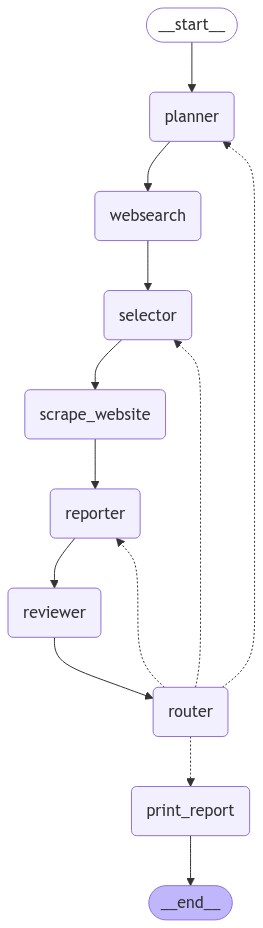

In [145]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [146]:
# Inputs
research_question = "Why is Maringá considered one of the warmest cities in the state of Paraná, Brazil?"
thread = {"configurable": {"thread_id": "1"}, "recursion_limit": 15}

# Run the graph until the first interruption
for event in graph.stream({"research_question": research_question}, 
                          thread, 
                          stream_mode="updates"):
    
    plan = event.get("planner", '')
    if plan:
        print("PLANNER")
        print(f"Search Term: {plan['planner_response'].search_term}")
        print(f"Overall Strategy: {plan['planner_response'].overall_strategy}")
        print(f"Additional Information: {plan['planner_response'].additional_information}")
        print("-" * 50, "\n")
        
    web_search = event.get("websearch", '')
    if web_search:
        print("WEBSEARCH")
        print(f"Serper Response: {web_search['serper_response']}")
        print("-" * 50, "\n")
    
    selected = event.get("selector", "")
    if selected:
        print("SELECTOR")
        print(f"Selected Page Url: {selected['selector_response'].selected_page_url}")
        print(f"Description: {selected['selector_response'].description}")
        print(f"Reason For Selection: {selected['selector_response'].reason_for_selection}")
        print("-" * 50, "\n")
        
    scrap = event.get("scrape_website", '')
    if scrap:
        print("SCRAPER")
        print(f"Scraper Response: {scrap['scraper_response'][-1].content}")
        print("-" * 50, "\n")
        
    report = event.get("reporter", "")
    if report:
        print("REPORTER")
        print(f"Reporter Response: {report['reporter_response'].content}")
        print("-" * 50, "\n")
        
    review = event.get("reviewer", "")
    if review:
        print("REVIEWER")
        print(f"Feedback: {review['reviewer_response'].feedback}")
        print(f"Pass Review: {review['reviewer_response'].pass_review}")
        print(f"Comprehensive: {review['reviewer_response'].comprehensive}")
        print(f"Citations Provided: {review['reviewer_response'].citations_provided}")
        print(f"Relevant to Research Question: {review['reviewer_response'].relevant_to_research_question}")
        print("-" * 50, "\n")
        
    route = event.get("router", "")
    if route:
        print("ROUTER")
        print(f"Next Agent: {route['router_response'].next_agent}")
        print("-" * 50, "\n")

PLANNER
Search Term: Maringá warmest city Paraná
Overall Strategy: Begin by searching for climate data and geographical information about Maringá. Look for studies or articles that discuss the climate characteristics of the city, including temperature averages, humidity levels, and any geographical factors that contribute to its warmth. Additionally, explore comparisons with other cities in Paraná to understand why Maringá stands out.
Additional Information: ['Maringá climate data', 'Maringá temperature averages', 'geographical factors Maringá', 'climate comparison Paraná cities', 'Maringá weather patterns']
-------------------------------------------------- 

WEBSEARCH
Serper Response: Title: Maringá climate: weather by month, temperature, rain
Link: https://www.climatestotravel.com/climate/brazil/maring%C3%A1
Snippet: January is generally a warm to hot, muggy month. The average temperature is of 25.4 °C (78 °F), with a minimum of 21 °C (69.7 °F) and a maximum of 29.8 °C (85.7 ...
---